In [ ]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/DATASET'

In [ ]:
# Initialize a dictionary to store file paths for each category
audio_files = {
    'Bonafide': [],
    'Spoofed_TTS': [],
    'Spoofed_Tacotron': []
}

# Iterate over the dataset folders (Bonafide, Spoofed_TTS, Spoofed_Tacotron)
for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
    category_path = os.path.join(dataset_path, category)

    for speaker_folder in os.listdir(category_path):
        speaker_path = os.path.join(category_path, speaker_folder)

        # Handle Bonafide folder with Part 1 and Part 2 subfolders
        if category == 'Bonafide':
            for part in ['Part 1', 'Part 2']:
                part_path = os.path.join(speaker_path, part)
                for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                    file_path = os.path.join(part_path, file)
                    if file.endswith('.wav'):  # Check if it's a valid audio file
                        audio_files[category].append(file_path)

        # Handle Spoofed_TTS and Spoofed_Tacotron (assuming these don't have parts)
        else:
            for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                file_path = os.path.join(speaker_path, file)
                if file.endswith('.wav'):  # Check if it's a valid audio file
                    audio_files[category].append(file_path)

# Check the loaded audio files
print("Bonafide files:", audio_files['Bonafide'])
print("Spoofed_TTS files:", audio_files['Spoofed_TTS'])
print("Spoofed_Tacotron files:", audio_files['Spoofed_Tacotron'])

Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:00<00:00, 76748.47it/s]

Bonafide files: ['/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/10.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/105.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/103.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/101.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/100.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/102.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/316.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/114.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/16.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/458.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/128.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/28.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/313.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/15.wav', '/content/drive/MyDri

In [ ]:
# Define subfolders
bonafide_path = os.path.join(dataset_path, 'Bonafide')
spoofed_tacotron_path = os.path.join(dataset_path, 'Spoofed_Tacotron')
spoofed_vits_tts_path = os.path.join(dataset_path, 'Spoofed_TTS')

# List all files in the dataset
def list_audio_files(folder_path):
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    return audio_files

bonafide_files = list_audio_files(bonafide_path)
spoofed_tacotron_files = list_audio_files(spoofed_tacotron_path)
spoofed_vits_tts_files = list_audio_files(spoofed_vits_tts_path)

print("Bonafied files:", bonafide_files)
print("Spoofed Tacotron files:", spoofed_tacotron_files)
print("Spoofed VitsTTS files:", spoofed_vits_tts_files)

Bonafied files: []
Spoofed Tacotron files: []
Spoofed VitsTTS files: []


In [ ]:
# STEP 1: Setup
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# STEP 2: Load .npy embeddings and labels
data_path = '/content/drive/MyDrive/'
x_train = np.load(data_path + 'x_train_embeddings.npy')
x_test = np.load(data_path + 'x_test_embeddings.npy')
y_train = np.load(data_path + 'y_train_labels.npy')
y_test = np.load(data_path + 'y_test_labels.npy')

# Reshape the embeddings to be 2D (batch_size, flattened_features)
# Assuming the embeddings are (batch_size, channels, height, width) -> (batch_size, channels * height * width)
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)


# Convert to tensors
# Use the flattened data for the tensors and the MLP input
x_train_tensor = torch.tensor(x_train_flattened, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test_flattened, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# STEP 3: Define MLP with Additive Attention
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        # The attention mechanism in this model receives a 2D input [batch, hidden_dim]
        # after the unsqueeze operation makes it [batch, seq=1, hidden_dim].
        # So, the Linear layer should operate on the last dimension (hidden_dim).
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x is expected to be [batch, seq_len, hidden_dim]
        # In this specific MLP, after unsqueeze, x is [batch, 1, hidden_dim]
        attn_weights = torch.softmax(self.attn(x), dim=1)  # [batch, seq_len, 1] -> [batch, 1, 1]
        context = torch.sum(attn_weights * x, dim=1)       # [batch, seq_len, 1] * [batch, seq_len, hidden_dim] -> [batch, hidden_dim]
        return context

class MLPWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLPWithAttention, self).__init__()
        # The first linear layer takes the flattened input dimension
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        # The attention layer expects input of shape [batch, seq_len, hidden_dim]
        # In this MLP, seq_len will be 1 after unsqueeze
        self.attn = AdditiveAttention(hidden_dim)
        # The second linear layer takes the output of the attention mechanism, which is [batch, hidden_dim]
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Input x shape is [batch, flattened_input_dim]
        x = self.relu(self.fc1(x))
        # After fc1 and relu, x shape is [batch, hidden_dim]
        x = x.unsqueeze(1)  # Add sequence dimension: [batch, seq=1, hidden_dim]
        # x shape is now [batch, 1, hidden_dim], ready for the attention layer
        x = self.attn(x)
        # After attention, x shape is [batch, hidden_dim]
        x = self.relu(self.fc2(x))
        # After fc2 and relu, x shape is [batch, hidden_dim]
        x = self.fc3(x)
        # Final output shape is [batch, output_dim]
        return x

# STEP 4: Initialize model
# Calculate the input_dim based on the flattened shape of the data
input_dim = x_train_flattened.shape[1]
model = MLPWithAttention(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# STEP 5: Train
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # inputs are now the flattened tensors [batch, flattened_input_dim]
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            # inputs are now the flattened tensors [batch, flattened_input_dim]
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | F1: {f1:.4f}")

# STEP 6: Final Evaluation
conf_matrix = confusion_matrix(all_labels, all_preds)
error_rate = 1 - acc
print("\nFinal Evaluation:")
print("Confusion Matrix:\n", conf_matrix)
print(f"Error Rate: {error_rate:.4f}")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, F1: {f1:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Epoch 1/20 | Loss: 88.8846 | Accuracy: 0.8642 | Precision: 0.8672 | F1: 0.8600
Epoch 2/20 | Loss: 59.2372 | Accuracy: 0.8921 | Precision: 0.9421 | F1: 0.8827
Epoch 3/20 | Loss: 47.3053 | Accuracy: 0.8818 | Precision: 0.9650 | F1: 0.8668
Epoch 4/20 | Loss: 40.7746 | Accuracy: 0.8561 | Precision: 0.9816 | F1: 0.8302
Epoch 5/20 | Loss: 31.6225 | Accuracy: 0.9317 | Precision: 0.8930 | F1: 0.9333
Epoch 6/20 | Loss: 28.7100 | Accuracy: 0.9515 | Precision: 0.9386 | F1: 0.9511
Epoch 7/20 | Loss: 23.4462 | Accuracy: 0.7827 | Precision: 0.9973 | F1: 0.7148
Epoch 8/20 | Loss: 26.8835 | Accuracy: 0.9207 | Precision: 0.9844 | F1: 0.9130
Epoch 9/20 | Loss: 22.9127 | Accuracy: 0.9706 | Precision: 0.9686 | F1: 0.9700
Epoch 10/20 | Loss: 18.4959 | Accuracy: 0.9244 | Precision: 0.9896 | F1: 0.9170
Epoch 11/20 | Loss: 24.2616 | Accuracy: 0.9677 | Precision: 0.

New data splitting:

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import drive
import h5py

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =======================
# STEP 1: Load embeddings
# =======================
# Assume embeddings are stored in numpy format: (speaker_id, utterance, embedding)
# and speaker_disjoint_split is already done — you load x_train.npy, y_train.npy, etc.

data_path = '/content/drive/MyDrive/'
x_train = np.load(data_path + 'x_train_embeddings.npy')
x_test = np.load(data_path + 'x_test_embeddings.npy')
y_train = np.load(data_path + 'y_train_labels.npy')
y_test = np.load(data_path + 'y_test_labels.npy')

# Flatten if needed (usually HuBERT outputs are already flat)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# =============================
# STEP 2: Define Model Classes
# =============================

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len=1, hidden_dim]
        attn_weights = torch.softmax(self.attn(x), dim=1)  # [batch, 1, 1]
        context = torch.sum(attn_weights * x, dim=1)       # [batch, hidden_dim]
        return context

class MLPWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLPWithAttention, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.attn = AdditiveAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = x.unsqueeze(1)  # [batch, 1, hidden_dim]
        x = self.attn(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ========================
# STEP 3: Training Process
# ========================
input_dim = 1024  # Fix: HuBERT BASE embedding dimension
print(f"x_train shape: {x_train.shape}")  # Should be (num_samples, 768)

model = MLPWithAttention(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    error_rate = 1 - acc

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | F1: {f1:.4f} | Error Rate: {error_rate:.4f}")

# ========================
# STEP 4: Save Model & Metrics
# ========================
save_path = '/content/drive/MyDrive'

# Save .pth
torch.save(model.state_dict(), os.path.join(save_path, 'newMLP_Attention_Model.pth'))

# Save .h5 using h5py
with h5py.File(os.path.join(save_path, 'newMLP_Attention_Model.h5'), 'w') as f:
    for name, param in model.named_parameters():
        f.create_dataset(name, data=param.detach().cpu().numpy())

# Save Evaluation Metrics
metrics_text = f"""
Final Evaluation:

Confusion Matrix:
{confusion_matrix(all_labels, all_preds)}

Accuracy: {acc:.4f}
Precision: {prec:.4f}
F1 Score: {f1:.4f}
Error Rate: {error_rate:.4f}
"""

with open(os.path.join(save_path, "mlp_attention_eval.txt"), "w") as f:
    f.write(metrics_text)

print("Model and metrics saved successfully!")


Using device: cpu
x_train shape: (5447, 1024)
Epoch 1/15 | Loss: 97.8697 | Acc: 0.7430 | Prec: 0.6636 | F1: 0.7855 | Error Rate: 0.2570
Epoch 2/15 | Loss: 61.6041 | Acc: 0.7797 | Prec: 0.9692 | F1: 0.7159 | Error Rate: 0.2203
Epoch 3/15 | Loss: 47.5732 | Acc: 0.8700 | Prec: 0.8037 | F1: 0.8797 | Error Rate: 0.1300
Epoch 4/15 | Loss: 40.4174 | Acc: 0.9258 | Prec: 0.9506 | F1: 0.9219 | Error Rate: 0.0742
Epoch 5/15 | Loss: 35.1444 | Acc: 0.9369 | Prec: 0.9560 | F1: 0.9339 | Error Rate: 0.0631
Epoch 6/15 | Loss: 32.7802 | Acc: 0.9508 | Prec: 0.9504 | F1: 0.9497 | Error Rate: 0.0492
Epoch 7/15 | Loss: 24.4117 | Acc: 0.9427 | Prec: 0.9061 | F1: 0.9439 | Error Rate: 0.0573
Epoch 8/15 | Loss: 35.1359 | Acc: 0.9126 | Prec: 0.8502 | F1: 0.9178 | Error Rate: 0.0874
Epoch 9/15 | Loss: 24.9353 | Acc: 0.9471 | Prec: 0.9775 | F1: 0.9441 | Error Rate: 0.0529
Epoch 10/15 | Loss: 21.0890 | Acc: 0.9589 | Prec: 0.9332 | F1: 0.9591 | Error Rate: 0.0411
Epoch 11/15 | Loss: 21.2617 | Acc: 0.9170 | Prec: 0.8

In [13]:
from sklearn.metrics import confusion_matrix

# Print Final Evaluation
print("\n=== Final Evaluation ===")
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print(f"Accuracy    : {acc:.4f}")
print(f"Precision   : {prec:.4f}")
print(f"F1 Score    : {f1:.4f}")
print(f"Error Rate  : {error_rate:.4f}")



=== Final Evaluation ===
Confusion Matrix:
[[676  20]
 [  9 657]]
Accuracy    : 0.9787
Precision   : 0.9705
F1 Score    : 0.9784
Error Rate  : 0.0213


testing (wrong answer)

In [3]:
!pip install torchaudio
!pip install librosa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [19]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the HuBERT model
bundle = torchaudio.pipelines.HUBERT_BASE
hubert_model = bundle.get_model().to(device)
hubert_model.eval()

def preprocess_audio(file_path, device):
    waveform, sample_rate = torchaudio.load(file_path)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    if sample_rate != bundle.sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=bundle.sample_rate)
        waveform = resampler(waveform)

    waveform = waveform.to(device)

    with torch.inference_mode():
        features, _ = hubert_model.extract_features(waveform)
        mean_last = features[-1].squeeze(0).mean(dim=0)               # 768-dim
        mean_middle = features[len(features)//2].squeeze(0).mean(dim=0)  # 256-dim
        mean_first_part = features[0].squeeze(0).mean(dim=0)[:256]    # take first 256-dim

        embedding = torch.cat([mean_last, mean_middle, mean_first_part], dim=0)  # [768+256+256 = 1280] ← Still too much
        embedding = embedding[:1024]  # Truncate to 1024-dim

        return embedding.unsqueeze(0)  # Shape: [1, 1024]


# Additive Attention
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(attn_weights * x, dim=1)
        return context

# MLP with Attention (matches training)
class MLPWithAttention(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=512, output_dim=2):
        super(MLPWithAttention, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.attn = AdditiveAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = x.unsqueeze(1)
        x = self.attn(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Load model
model = MLPWithAttention(input_dim=1024).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/newMLP_Attention_Model.pth', map_location=device))
model.eval()

# Inference
test_audio_path = '/content/urdu_test_audio.mp3'
embedding = preprocess_audio(test_audio_path, device)
embedding = preprocess_audio(test_audio_path, device)
print(embedding.shape)  # Must say: torch.Size([1, 1024])

with torch.no_grad():
    logits = model(embedding)
    probs = F.softmax(logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_class].item()

# Output
label_map = {0: 'Bonafide (Real)', 1: 'Spoofed (Fake)'}
print(f"\nPrediction: {label_map[pred_class]}")
print(f"Confidence Score: {confidence:.4f}")


torch.Size([1, 1024])

Prediction: Bonafide (Real)
Confidence Score: 0.9810


dropout and fixxing(high accuracy)

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import h5py

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =====================
# STEP 1: Load Data
# =====================
data_path = '/content/drive/MyDrive/'
x_train = np.load(data_path + 'x_train_embeddings.npy')
x_test = np.load(data_path + 'x_test_embeddings.npy')
y_train = np.load(data_path + 'y_train_labels.npy')
y_test = np.load(data_path + 'y_test_labels.npy')

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32)

# =====================
# STEP 2: Define Model
# =====================
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(attn_weights * x, dim=1)
        return context

class MLPWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLPWithAttention, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.attn = AdditiveAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = x.unsqueeze(1)
        x = self.attn(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# =====================
# STEP 3: Train
# =====================
input_dim = x_train.shape[1]
model = MLPWithAttention(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

best_f1 = 0
patience = 5
trigger_times = 0

epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Eval
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    err = 1 - acc

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | F1: {f1:.4f} | Err: {err:.4f}")

    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        trigger_times = 0
        torch.save(model.state_dict(), os.path.join(data_path, 'best_model.pth'))
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping.")
            break

# =====================
# STEP 4: Save Final
# =====================
model.load_state_dict(torch.load(os.path.join(data_path, 'best_model.pth')))

# Save to .h5
with h5py.File(os.path.join(data_path, 'best_model.h5'), 'w') as f:
    for name, param in model.named_parameters():
        f.create_dataset(name, data=param.cpu().detach().numpy())

print("✅ Model saved after early stopping.")


Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Loss: 104.2809 | Acc: 0.7151 | Prec: 0.8994 | F1: 0.6174 | Err: 0.2849
Epoch 2/30 | Loss: 83.4722 | Acc: 0.8443 | Prec: 0.8135 | F1: 0.8475 | Err: 0.1557
Epoch 3/30 | Loss: 73.2092 | Acc: 0.8598 | Prec: 0.8033 | F1: 0.8682 | Err: 0.1402
Epoch 4/30 | Loss: 67.6657 | Acc: 0.8877 | Prec: 0.9184 | F1: 0.8804 | Err: 0.1123
Epoch 5/30 | Loss: 72.2034 | Acc: 0.8825 | Prec: 0.9134 | F1: 0.8748 | Err: 0.1175
Epoch 6/30 | Loss: 68.4594 | Acc: 0.9023 | Prec: 0.8696 | F1: 0.9041 | Err: 0.0977
Epoch 7/30 | Loss: 75.7255 | Acc: 0.6696 | Prec: 0.5971 | F1: 0.7469 | Err: 0.3304
Epoch 8/30 | Loss: 76.0292 | Acc: 0.8686 | Prec: 0.8010 | F1: 0.8786 | Err: 0.1314
Epoch 9/30 | Loss: 79.5579 | Acc: 0.8715 | Prec: 0.8050 | F1: 0.8810 | Err: 0.1285
Epoch 10/30 | Loss: 72.3361 | Acc: 0.8502 | Prec: 0.9695 | F1: 0.8238 | Err: 0.1498
Epoch 11/30 | Loss: 60.4785 | Acc: 0.9214 | Prec: 0.9080 | F1: 0.9208 | Err: 0.0786
Epoch 12/30 | Loss: 54.9907 | Acc: 0.9112 | Prec: 0.8801 | F1: 0.9125 | Err: 0.0888



🧾 Final Evaluation Metrics:
Accuracy     : 0.9457
Precision    : 0.9444
F1 Score     : 0.9444
Error Rate   : 0.0543

Confusion Matrix:
[[659  37]
 [ 37 629]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       696
           1       0.94      0.94      0.94       666

    accuracy                           0.95      1362
   macro avg       0.95      0.95      0.95      1362
weighted avg       0.95      0.95      0.95      1362


📁 Metrics saved to: /content/drive/MyDrive/final_eval_metrics.txt


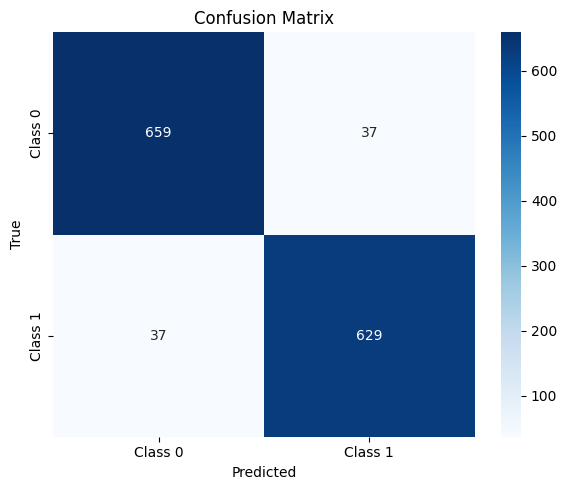

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Evaluate model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
err = 1 - acc
cm = confusion_matrix(all_labels, all_preds)

# Print metrics
print("\n🧾 Final Evaluation Metrics:")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Error Rate   : {err:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Save metrics to text file
metrics_path = os.path.join(save_path, "final_eval_metrics.txt")
with open(metrics_path, "w") as f:
    f.write(f"Final Evaluation Metrics:\n\n")
    f.write(f"Accuracy     : {acc:.4f}\n")
    f.write(f"Precision    : {prec:.4f}\n")
    f.write(f"F1 Score     : {f1:.4f}\n")
    f.write(f"Error Rate   : {err:.4f}\n\n")
    f.write(f"Confusion Matrix:\n{cm}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(all_labels, all_preds))

print(f"\n📁 Metrics saved to: {metrics_path}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "confusion_matrix.png"))
plt.show()


for loss curves training it again and saving in drive (FInal code)

Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25 | Loss: 110.5818 | Acc: 0.6865 | Prec: 0.6470 | F1: 0.7113 | Err: 0.3135
Epoch 2/25 | Loss: 93.8049 | Acc: 0.6711 | Prec: 0.6015 | F1: 0.7425 | Err: 0.3289
Epoch 3/25 | Loss: 84.4417 | Acc: 0.8311 | Prec: 0.9258 | F1: 0.8048 | Err: 0.1689
Epoch 4/25 | Loss: 79.9090 | Acc: 0.7966 | Prec: 0.9431 | F1: 0.7493 | Err: 0.2034
Epoch 5/25 | Loss: 81.6953 | Acc: 0.7570 | Prec: 0.9666 | F1: 0.6771 | Err: 0.2430
Epoch 6/25 | Loss: 80.9910 | Acc: 0.8671 | Prec: 0.8795 | F1: 0.8613 | Err: 0.1329
Epoch 7/25 | Loss: 78.7259 | Acc: 0.8862 | Prec: 0.9114 | F1: 0.8796 | Err: 0.1138
Epoch 8/25 | Loss: 79.9579 | Acc: 0.8744 | Prec: 0.9396 | F1: 0.8609 | Err: 0.1256
Epoch 9/25 | Loss: 72.5731 | Acc: 0.9075 | Prec: 0.9193 | F1: 0.9038 | Err: 0.0925
Epoch 10/25 | Loss: 70.5739 | Acc: 0.9075 | Prec: 0.8782 | F1: 0.9087 | Err: 0.0925
Epoch 11/25 | Loss: 74.5326 | Acc: 0.8899 | Prec: 0.9121 | F1: 0.8839 | Err: 0.1101
Epoch 12/25 | Loss: 82.2862 | Acc: 0.9141 | Prec: 0.9350 | F1: 0.9098 | Err: 0.0859


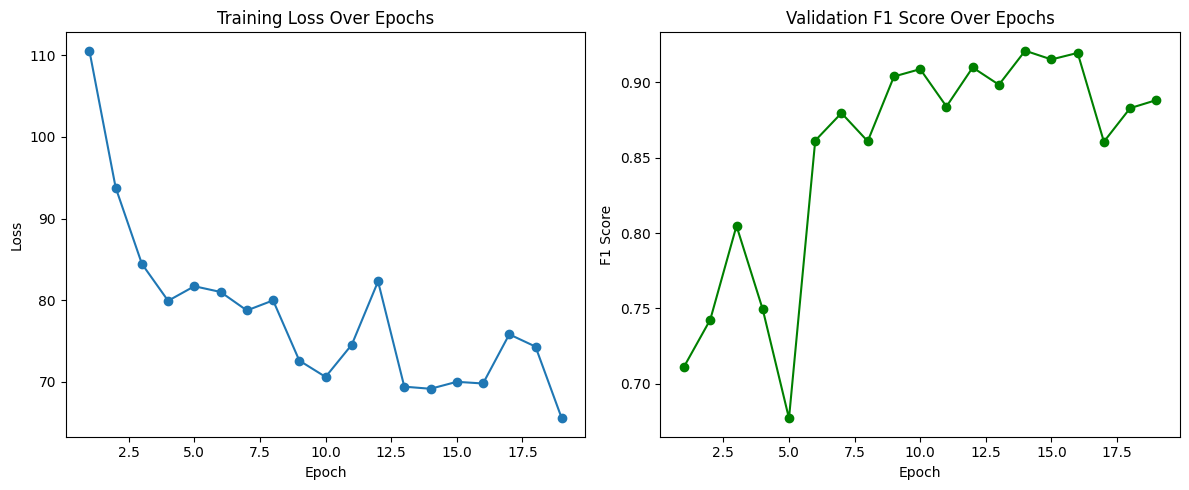

✅ Model and metrics saved successfully.

✅ Final Evaluation on Test Set:
Accuracy:  0.9214
Precision: 0.9068
F1 Score:  0.9209
Error Rate: 0.0786
Confusion Matrix:
[[632  64]
 [ 43 623]]


In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import h5py

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =====================
# STEP 1: Load Data
# =====================
data_path = '/content/drive/MyDrive/'
x_train = np.load(data_path + 'x_train_embeddings.npy')
x_test = np.load(data_path + 'x_test_embeddings.npy')
y_train = np.load(data_path + 'y_train_labels.npy')
y_test = np.load(data_path + 'y_test_labels.npy')

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32)

# =====================
# STEP 2: Define Model
# =====================
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(attn_weights * x, dim=1)
        return context

class MLPWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLPWithAttention, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.6)
        self.attn = AdditiveAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = x.unsqueeze(1)
        x = self.attn(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# =====================
# STEP 3: Train
# =====================
input_dim = x_train.shape[1]
model = MLPWithAttention(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

best_f1 = 0
patience = 5
trigger_times = 0
epochs = 25

train_losses, val_f1s = [], []
metrics_log = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    err = 1 - acc

    train_losses.append(total_loss)
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | F1: {f1:.4f} | Err: {err:.4f}")
    metrics_log.append([epoch+1, total_loss, acc, prec, f1, err])

    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        trigger_times = 0
        torch.save(model.state_dict(), os.path.join(data_path, 'nn_finetune.pth'))
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping.")
            break

# =====================
# STEP 4: Save Model & Metrics
# =====================
model.load_state_dict(torch.load(os.path.join(data_path, 'nn_finetune.pth')))

# Save to .h5
with h5py.File(os.path.join(data_path, 'nn_finetune.h5'), 'w') as f:
    for name, param in model.named_parameters():
        f.create_dataset(name, data=param.cpu().detach().numpy())

# Save evaluation metrics
metrics_df = pd.DataFrame(metrics_log, columns=['Epoch', 'Train_Loss', 'Accuracy', 'Precision', 'F1_Score', 'Error_Rate'])
metrics_df.to_csv(os.path.join(data_path, 'nn_finetune_ev.csv'), index=False)

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_f1s)+1), val_f1s, marker='o', color='green')
plt.title('Validation F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.savefig(os.path.join(data_path, 'learning_curves.png'))
plt.show()

print("✅ Model and metrics saved successfully.")
# =====================
# STEP 5: Final Evaluation on Test Set
# =====================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

final_acc = accuracy_score(all_labels, all_preds)
final_prec = precision_score(all_labels, all_preds)
final_f1 = f1_score(all_labels, all_preds)
final_err = 1 - final_acc
conf_mat = confusion_matrix(all_labels, all_preds)

print("\n✅ Final Evaluation on Test Set:")
print(f"Accuracy:  {final_acc:.4f}")
print(f"Precision: {final_prec:.4f}")
print(f"F1 Score:  {final_f1:.4f}")
print(f"Error Rate: {final_err:.4f}")
print(f"Confusion Matrix:\n{conf_mat}")


In [29]:
import torch
import torch.nn as nn
import numpy as np
import librosa
import os

# ======= Model Definition (same as training) =======
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(attn_weights * x, dim=1)
        return context

class MLPWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLPWithAttention, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.6)
        self.attn = AdditiveAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = x.unsqueeze(1)  # Add sequence dimension for attention
        x = self.attn(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# ======= Feature extraction to match training =======
def extract_embedding_from_mp3(mp3_path):
    y, sr = librosa.load(mp3_path, sr=16000)  # Use same sample rate as training
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=32, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or truncate to 32 time frames
    if mel_spec_db.shape[1] < 32:
        pad_width = 32 - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0,0),(0,pad_width)), mode='constant', constant_values=mel_spec_db.min())
    else:
        mel_spec_db = mel_spec_db[:, :32]

    embedding = mel_spec_db.flatten()  # flatten 32x32 = 1024 vector
    return embedding

# ======= Classification function =======
def classify_audio(mp3_path, model_path, input_dim):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPWithAttention(input_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    emb = extract_embedding_from_mp3(mp3_path)
    print(f"Extracted embedding shape: {emb.shape}")  # Should print (1024,)
    emb = emb.reshape(1, -1)
    emb_tensor = torch.tensor(emb, dtype=torch.float32).to(device)

    with torch.no_grad():
        out = model(emb_tensor)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        pred_class = np.argmax(probs)

    labels = {0: 'Real', 1: 'Fake'}
    print(f"Prediction: {labels[pred_class]} (Confidence: {probs[0][pred_class]*100:.2f}%)")
    return labels[pred_class], probs[0][pred_class]

# ======= Usage Example =======
if __name__ == "__main__":
    mp3_path = '/content/urdu_test_audio.mp3'   # Your test audio path
    data_path = '/content/drive/MyDrive/'
    model_path = os.path.join(data_path, 'nn_finetune.pth')

    # Load training embeddings just to get input_dim
    x_train = np.load(data_path + 'x_train_embeddings.npy')
    print(f"x_train original shape: {x_train.shape}")  # Expect (num_samples, 1, 32, 32)

    # Flatten training embeddings to get input_dim
    x_train = x_train.reshape(x_train.shape[0], -1)
    print(f"x_train reshaped: {x_train.shape}")  # Expect (num_samples, 1024)

    input_dim = x_train.shape[1]  # 1024
    print(f"Using input_dim = {input_dim}")

    classify_audio(mp3_path, model_path, input_dim)


x_train original shape: (5447, 1, 32, 32)
x_train reshaped: (5447, 1024)
Using input_dim = 1024
Extracted embedding shape: (1024,)
Prediction: Fake (Confidence: 100.00%)


In [31]:
import torch
import torch.nn as nn
import numpy as np
import librosa
import os

# ======= Model Definition (same as training) =======
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(attn_weights * x, dim=1)
        return context

class MLPWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLPWithAttention, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.6)
        self.attn = AdditiveAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = x.unsqueeze(1)  # Add sequence dimension for attention
        x = self.attn(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# ======= Feature extraction to match training =======
def extract_embedding_from_mp3(mp3_path):
    y, sr = librosa.load(mp3_path, sr=16000)  # Use same sample rate as training
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=32, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or truncate to 32 time frames
    if mel_spec_db.shape[1] < 32:
        pad_width = 32 - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0,0),(0,pad_width)), mode='constant', constant_values=mel_spec_db.min())
    else:
        mel_spec_db = mel_spec_db[:, :32]

    embedding = mel_spec_db.flatten()  # flatten 32x32 = 1024 vector
    return embedding

# ======= Classification function =======
def classify_audio(mp3_path, model_path, input_dim):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPWithAttention(input_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    emb = extract_embedding_from_mp3(mp3_path)
    print(f"Extracted embedding shape: {emb.shape}")  # Should print (1024,)
    emb = emb.reshape(1, -1)
    emb_tensor = torch.tensor(emb, dtype=torch.float32).to(device)

    with torch.no_grad():
        out = model(emb_tensor)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        pred_class = np.argmax(probs)

    labels = {0: 'Real', 1: 'Fake'}
    print(f"Prediction: {labels[pred_class]} (Confidence: {probs[0][pred_class]*100:.2f}%)")
    return labels[pred_class], probs[0][pred_class]

# ======= Usage Example =======
if __name__ == "__main__":
    mp3_path = '/content/Recording.mp3'   # Your test audio path
    data_path = '/content/drive/MyDrive/'
    model_path = os.path.join(data_path, 'nn_finetune.pth')

    # Load training embeddings just to get input_dim
    x_train = np.load(data_path + 'x_train_embeddings.npy')
    print(f"x_train original shape: {x_train.shape}")  # Expect (num_samples, 1, 32, 32)

    # Flatten training embeddings to get input_dim
    x_train = x_train.reshape(x_train.shape[0], -1)
    print(f"x_train reshaped: {x_train.shape}")  # Expect (num_samples, 1024)

    input_dim = x_train.shape[1]  # 1024
    print(f"Using input_dim = {input_dim}")

    classify_audio(mp3_path, model_path, input_dim)


x_train original shape: (5447, 1, 32, 32)
x_train reshaped: (5447, 1024)
Using input_dim = 1024
Extracted embedding shape: (1024,)
Prediction: Fake (Confidence: 100.00%)
